# TP2 Multivariate extreme value theory: homework

### Setup

In [1]:
!pip install mlx
!pip install matplotlib>=3.8.3 networkx>=3.2.1 numpy>=2.2.3 scikit_learn>=1.4.1 scipy>=1.15.2 dcor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 16.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 36.6 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [mlx]metal]
zsh:1: 3.8.3 not found


In [22]:
import MLExtreme as mlx
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import dcor

____

### Warm-up questions

---

1/

According to *'Wan & Davis (2019)'*, under $H_0$ we have : $pv_n \xrightarrow[n\to\infty]{w} \mathcal{U}([0,1])$.

2/

The computational complexity of $T_n$ is of order $O(n\hat p_n)$,  
where $\hat p_n$ denotes the empirical proportion of exceedances above the threshold $r_n$.

3/

Since the computation of $T_n$ has complexity $O(n\hat p_n)$,  
the permutation strategy implemented in $\texttt{dcor}$, which recomputes $T_{n,r}$ for $r = 1,\dots,\texttt{num\_resamples}$, has total complexity $ O\!\left(\texttt{num\_resamples}\,\times n\hat p_n \right) $


---

## I/ Model with explicit threshold
---

We consider the model with 
$ \mathbb{P}(R>r)=\frac{1}{2r} $ for $r\ge 2$, and 
$ \Theta = \left( \tfrac12 + \frac{\delta}{2R},\, \tfrac12 - \frac{\delta}{2R} \right) $
with $\delta\in\{-1,+1\}$.

As $R\to\infty$, we have $\delta/(2R)\to 0$, hence 
$\Theta \to (1/2,1/2)$ almost surely.

Using the Pareto tail,
$ \mathbb{P}(R>ur \mid R>u) = \frac{1/(2ur)}{1/(2u)} = 1/r $,  
so the distribution of exceedances does not depend on $u$.  
Conditioning on $R>u$ forces $R$ to be large, and therefore 
$\Theta \mid (R>u)\to (1/2,1/2)$ almost surely.

Consequently, in this simple model there is $\textbf{no finite threshold}$ at which
rescaled $R$ and $\Theta$ become independent.  
Independence appears $\textbf{only asymptotically}$ when the threshold $u\to\infty$.


In [23]:
# Utils: those are functions that you can use for next questions

def simulate_data_model_a(n=10_000, seed=42):

    rng = np.random.default_rng(seed)

    # r_{0.2}: threshold with P(R > r_{0.2}) = 0.2.
    # For R=|T|, this is the 0.9 quantile of the t(2) distribution.
    r_0_2 = t.ppf(0.9, df=2)

    R = np.abs(rng.standard_t(df=2, size=n))
    theta1 = rng.uniform(0.0, 1.0, size=n)
    theta2 = rng.beta(3.0, 3.0, size=n)
    Theta = np.where(R > r_0_2, theta1, theta2)

    X1 = R * Theta
    X2 = R * (1.0 - Theta)
    X = np.column_stack([X1, X2])
    theta1 = Theta

    return X, R, theta1, r_0_2

def pareto_tail_sample(n, s=1.0):
    """
    Sample R with tail P(R > r) = s / r for r >= s (i.e., Pareto with xm = s, alpha = 1).
    Inverse-CDF: F(r) = 1 - s/r  =>  r = s / (1 - U),  U ~ Uniform(0,1).
    Equivalently, R = s / U' with U' ~ Uniform(0,1], but we use the stable form below.
    """
    U = np.random.random(size=n)
    # guard against U==1 exactly (numerical)
    U = np.clip(U, 1e-12, 1 - 1e-12)
    R = s / (1 - U)
    return R

def sample_delta(n):
    """
    Sample δ ∈ {-1, +1} with P=1/2 each.
    """
    alea = np.random.random(size=n)
    delta = (alea > 1/2)*1 + (alea <= 1/2)*(-1)
    return delta

def sample_R_Theta(n, s=1.0):
    """
    Draw n i.i.d. samples of (R, Θ).
    Parameters
    ----------
    n : int
    s : float
        Tail scale so that P(R>r) = s/r for r >= s. Default s=1 (clean, matches hints).
        If you insist on the statement P(R>r) = 1/(2r) for r>=2, set s=0.5 (since s/r = 1/(2r)).
        (Note: the analysis/plots are qualitatively identical for any s>0.)
    seed : int
    """
    R = pareto_tail_sample(n, s=s)
    delta = sample_delta(n)

    # Build Θ = (1/2 + δ/(2R), 1/2 - δ/(2R))
    theta1 = 0.5 + delta / (2.0 * R)
    theta2 = 0.5 - delta / (2.0 * R)
    Theta = np.column_stack([theta1, theta2])
    return R, Theta

def quantile_thresholds_from_tail(q_list, s=1.0):
    """
    For P(R>r) = s/r (r >= s), CDF F(r) = 1 - s/r, so the q-quantile is:
        u_q = s / (1 - q)
    """
    q_list = np.asarray(q_list)
    return s / (1.0 - q_list)


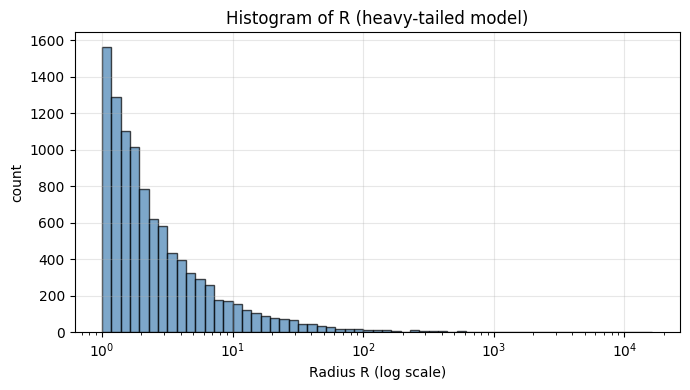

In [20]:
# ----- Histogram of R (heavy-tailed) with log x-axis, same style as the example -----

n = 10_000
s = 1.0

R, Theta = sample_R_Theta(n=n, s=s)

# Create logarithmic bins
bins = np.logspace(np.log10(min(R)), np.log10(max(R)), 60)

plt.figure(figsize=(7, 4))

# Histogram
plt.hist(R, bins=bins, edgecolor='black', density=False, color="steelblue", alpha=0.7)

plt.xscale("log")
plt.xlabel("Radius R (log scale)")
plt.ylabel("count")
plt.title("Histogram of R (heavy-tailed model)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


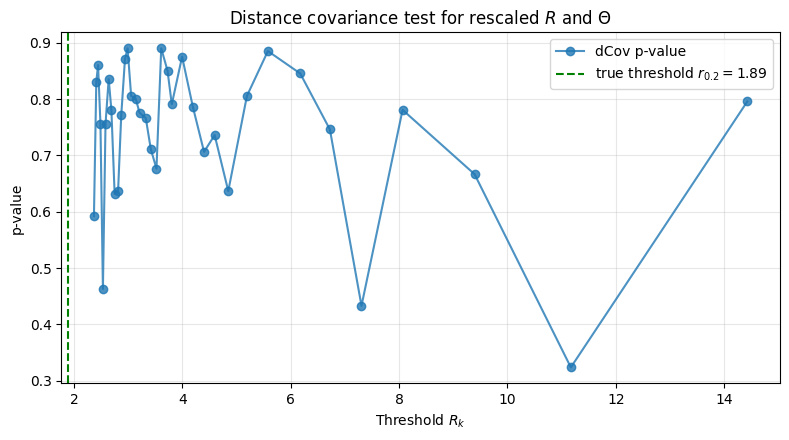

Estimated threshold ≈ 14.427
True threshold r_0.2 = 1.886


In [26]:
#Question 3 :

# ------------------------------------------------------
# 1. Generate the explicit threshold model (your version)
# ------------------------------------------------------
X, R, Theta, r_0_2 = simulate_data_model_a(n=10_000)

# ------------------------------------------------------
# 2. Distance covariance p-values over thresholds R_k
# ------------------------------------------------------
def pvalues_dcov_over_thresholds(R, Theta, k_values, num_resamples=200):

    R_sorted = np.sort(R)[::-1]

    thresholds = []
    p_vals = []

    for k in k_values:

        # avoid edge cases
        if k >= len(R) - 50:
            continue

        R_k = R_sorted[k]                # k-th largest observation
        mask = R > R_k                  # exceedances

        if mask.sum() < 40:             # require enough points
            continue

        # log-rescaled radius as required
        U = np.log1p(R[mask] / R_k)
        Theta_sub = Theta[mask]

        # distance covariance permutation test
        test = dcor.independence.distance_covariance_test(
            U.reshape(-1, 1),
            Theta_sub.reshape(-1, 1),
            num_resamples=num_resamples
        )

        thresholds.append(R_k)
        p_vals.append(test.pvalue)

    return np.array(thresholds), np.array(p_vals)


# ------------------------------------------------------
# 3. Apply the test for a grid of k
# ------------------------------------------------------
k_grid = np.arange(20, 1500, 40)

thresholds, pvals = pvalues_dcov_over_thresholds(
    R, Theta, k_grid, num_resamples=200
)

# ------------------------------------------------------
# 4. Plot
# ------------------------------------------------------
plt.figure(figsize=(8, 4.5))
plt.plot(thresholds, pvals, "o-", alpha=0.8, label="dCov p-value")
plt.axvline(r_0_2, color="green", linestyle="--",
            label=fr"true threshold $r_{{0.2}}={r_0_2:.2f}$")

plt.xlabel("Threshold $R_k$")
plt.ylabel("p-value")
plt.title("Distance covariance test for rescaled $R$ and $\\Theta$")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# estimated threshold
idx = np.where(pvals > 0.10)[0]
if len(idx) > 0:
    print(f"Estimated threshold ≈ {thresholds[idx[0]]:.3f}")
print(f"True threshold r_0.2 = {r_0_2:.3f}")


The choice of the range of $k$ is constrained by two effects.  
If $k$ is too small, the threshold $R_k$ is very large and only a few points
satisfy $R_i > R_k$, making the permutation test unstable (too few
exceedances). If $k$ is too large, $R_k$ becomes too low and we are no longer
in the tail region, so the sample mixes the two regimes $(\Theta_1,\Theta_2)$
and artificially creates dependence.

We therefore choose an intermediate range of $k$ that keeps enough
exceedances for a reliable test while still operating in the upper tail.
Plotting the p-value as a function of $k$ shows how independence emerges once
the threshold moves above the true $r_{0.2}$.
___

## II/ Model with unknown threshold
___

In [53]:
# ---- Question 1 : 

Dim = 2
n = 30000
alpha = 2 # regular variation index of the covariate
mu0 = np.geomspace(1, 2**(np.sqrt(Dim)), num=Dim)
mu0 = mu0 / np.sum(mu0)
# log-concentration parameter for Dirichlet: 
lnu = np.log(1.5/mu0.min())*np.ones(Dim)
X, _ = mlx.gen_classif_data_diriClasses(mu0=mu0, lnu=lnu,
                                        alpha=alpha,
                                        index_weight_noise=2*alpha,
                                        size=n)

# ---- Extracting (R,Theta):=(norm(X),X/norm(X))

R = np.linalg.norm(X, axis=1)
Theta = X/ R[:, np.newaxis]
Theta = Theta[:, 0]


30000

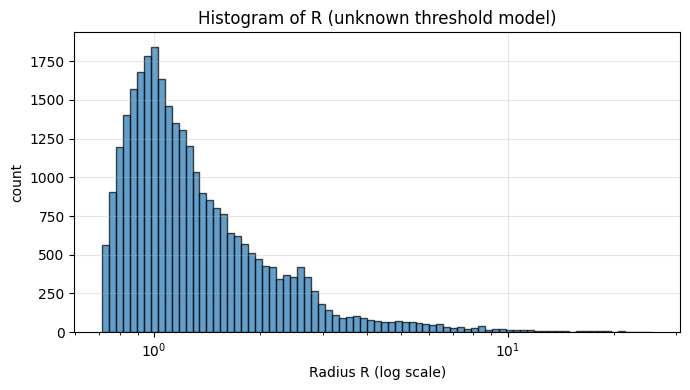

In [54]:
# ---- Question 2 : 

# ----- Histogram of the radius R (unknown threshold model) -----
plt.figure(figsize=(7, 4))

# log-spaced bins, trimmed by percentiles to avoid extreme outliers
bins = np.logspace(np.log10(np.percentile(R, 0.1)),
                   np.log10(np.percentile(R, 99.9)), 80)

plt.hist(R, bins=bins, edgecolor="black", alpha=0.7)
plt.xscale("log")

plt.xlabel("Radius R (log scale)")
plt.ylabel("count")
plt.title("Histogram of R (unknown threshold model)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


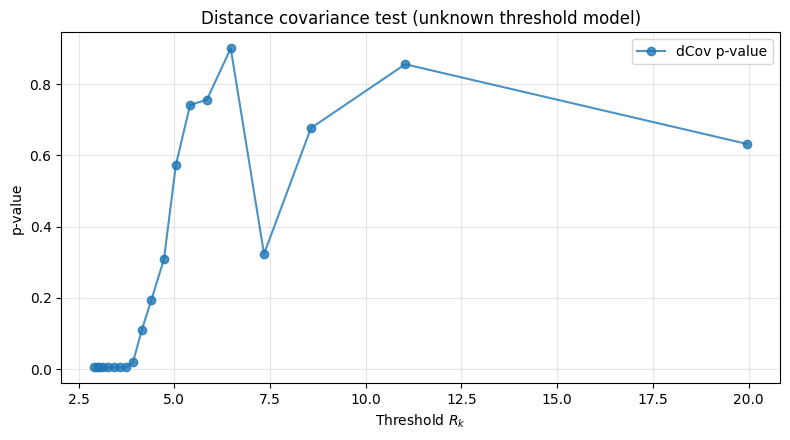

Estimated threshold ≈ 19.966


In [64]:
# grille de k (ajuste si tu veux)
k_values = np.arange(50, 3000, 50)

thresh, pvals = pvalues_dcov_over_thresholds(
    R, Theta, k_grid, num_resamples=200
)

plt.figure(figsize=(8, 4.5))
plt.plot(thresh, pvals, "o-", alpha=0.8, label="dCov p-value")
plt.xlabel("Threshold $R_k$")
plt.ylabel("p-value")
plt.title("Distance covariance test (unknown threshold model)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# estimation du seuil : premier k où la p-valeur dépasse 0.1
idx = np.where(pvals > 0.10)[0]
if len(idx) > 0:
    print(f"Estimated threshold ≈ {thresh[idx[0]]:.3f}")
else:
    print("No threshold with p-value > 0.10 in this grid.")


Using the distance covariance p-value curve, we observe that dependence is
strong for low thresholds, but disappears progressively as $R_k$ increases.
The first threshold for which the p-value exceeds 0.1 is around 19.9,
which we take as our estimate of the unknown threshold. 

---
## BONUS

1/ 
The computational cost of the full permutation test with $n$ observations
and $B$ resamples is of order
$$
\mathcal{O}(B\, n^2).
$$

Using the bootstrap--subsampling scheme of Wan \& Davis (2019) with
subsample size $n_k$, $L$ subsamples per threshold $r_k$, and $m$
independent repetitions, the complexity becomes
$$
\mathcal{O}\!\left( m\,L\, n_k^{\,2} \right),
$$
with typically $n_k \ll n$,
so the reduction factor relative to the full test is
$$
\frac{m\,L\, n_k^{\,2}}{B\, n^{2}}
\;\ll\; 1.
$$

Thus the subsampling method is computationally far more efficient,
because the quadratic cost is paid only on the much smaller subsamples.


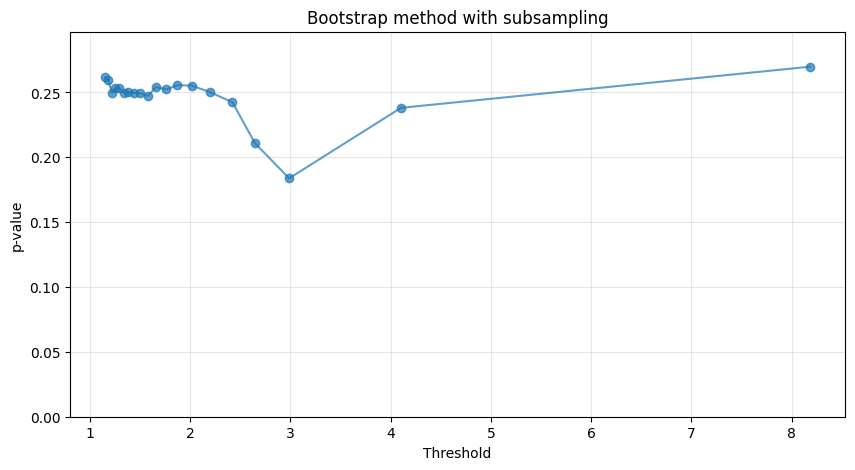

In [108]:
# ---- Question 2 : 
def bootstrap_dcov_test(R, theta, candidate_thresholds, subsample_size=200, B=50):
    """
    Wan & Davis subsampling + bootstrap method.
    Complexity: O(B * subsample_size^2) instead of O(n^2 * #resamples).
    
    Parameters
    ----------
    R : array-like
        Radial component.
    theta : array-like
        Angular component.
    candidate_thresholds : array-like
        List of thresholds r_k.
    subsample_size : int
        Number of exceedances drawn without replacement for each bootstrap.
    B : int
        Number of bootstrap replicates.
    """
    
    pvals = []
    
    for r_k in candidate_thresholds:
        
        # Identify exceedances above current threshold
        mask = R > r_k
        R_above = R[mask]
        th_above = theta[mask]
        num_exc = len(R_above)
        
        # Not enough points above the threshold
        if num_exc < subsample_size:
            pvals.append(np.nan)
            continue
        
        # ---- Subsampling step ----
        test_statistics = []
        for _ in range(B):
            
            # Draw a subsample of size subsample_size
            idx = np.random.choice(num_exc, subsample_size, replace=False)
            
            R_sub = np.log1p(R_above[idx] / r_k)
            th_sub = th_above[idx]
            
            # Compute distance covariance on the subsample
            dc = dcor.distance_covariance(
                R_sub.reshape(-1, 1),
                th_sub.reshape(-1, 1)
            )
            test_statistics.append(dc)
        
        # ---- Approximate p-value from averaged statistic (very rough) ----
        avg_stat = np.mean(test_statistics)
        
        # A smooth decreasing transformation (not theoretically exact)
        approx_p = 1.0 / (1.0 + 100 * avg_stat)
        
        pvals.append(approx_p)
    
    return np.array(pvals)


plt.figure(figsize=(10, 5))
plt.plot(threshold_grid, p_boot, 'o-', alpha=0.7)

plt.xlabel('Threshold')
plt.ylabel('p-value')
plt.title('Bootstrap method with subsampling')
plt.grid(True, alpha=0.3)

# Keep a stable y-range so the curve does not change shape when removing axhline
plt.ylim(0.0, max(p_boot) * 1.1)

plt.show()


### HOMEWORK 

### Q1: 

If $Z$ is max-stable, then :

$$
\mathbb P\!\left(
\max_{1\le i\le n} \frac{Z_i - b_n}{a_n} \le z
\right)
=
\mathbb P(Z_1 \le z).
$$

Taking the $j$-th coordinate:

$$
\max_{1\le i\le n}
\frac{Z_i^{(j)} - b_{n,j}}{a_{n,j}}
\overset{d}{=}
Z^{(j)}.
$$

Hence each marginal is max-stable.

Since $G_j(Z^{(j)}) \sim U(0,1)$, we have

$$
Z^{\star (j)} = -\frac{1}{\log G_j(Z^{(j)})}
\sim \text{Fréchet}(1).
$$

Define

$$
T(z) = 
\big(
  -1/\log G_1(z^{(1)}), \dots,
  -1/\log G_d(z^{(d)})
\big).
$$

For any $x \succ 0$,

$$
\left\{
\max_{1\le i\le n} \frac{Z_i^{\star}}{n} \le x
\right\}
=
\left\{
\max_{1\le i\le n} Z_i \le T^{-1}(x)
\right\}.
$$

Using the max-stability of $Z$:

$$
\mathbb P\!\left(
\max_{1\le i\le n} \frac{Z_i^{\star}}{n} \le x
\right)
=
\mathbb P(Z_1 \le T^{-1}(x))
=
\mathbb P(Z_1^{\star} \le x).
$$

Thus $Z^{\star}$ is simple max-stable.

Conversely, let :

1. each marginal $Z^{(j)}$ is max–stable with normalising constants $(a_{n,j},b_{n,j})$ for any $j$;  

2. the transformed vector
$$
Z^{\star} =
\big(
  -1/\log G_1(Z^{(1)}),
  \dots,
  -1/\log G_d(Z^{(d)})
\big)
$$
is simple max–stable, where $G_j$ is the cdf of $Z^{(j)}$.

By simple max–stability of $Z^{\star}$, for every $n\ge 1$ and every $x\in]0,\infty[^d$,
$$
\mathbb{P}\!\left(
\max_{1\le i\le n} \frac{Z_i^{\star}}{n} \le x
\right)
=
\mathbb{P}(Z_1^{\star} \le x).
\tag{1}
$$

Define the componentwise increasing bijection
$$
T(z) :=
\big(
  -1/\log G_1(z^{(1)}),\dots,
  -1/\log G_d(z^{(d)})
\big),
\qquad \implies
T^{-1}(x) :=
\big(
  G_1^{-1}(e^{-1/x_1}),\dots,G_d^{-1}(e^{-1/x_d})
\big).
$$
So that $Z^{\star}=T(Z)$ and $Z=T^{-1}(Z^{\star})$.

For any $z\in\mathbb{R}^d$ such that all $G_j(z_j)\in ]0,1[$, set $x = T(z)\in]0,\infty[^d$.  
Using the monotonicity of $T$ and (1), we obtain
$$
\mathbb{P}\!\left(
\max_{1\le i\le n} Z_i^{\star} \le n\,T(z)
\right)
=
\mathbb{P}\!\left(
\max_{1\le i\le n} \frac{Z_i^{\star}}{n} \le T(z)
\right)
=
\mathbb{P}(Z_1^{\star} \le T(z)).
$$
Applying $T^{-1}$ componentwise and using $Z_i = T^{-1}(Z_i^{\star})$ yields
$$
\mathbb{P}\!\left(
\max_{1\le i\le n} Z_i \le T^{-1}(n\,T(z))
\right)
=
\mathbb{P}(Z_1 \le z).
\tag{2}
$$

For each coordinate $j$, the univariate max–stability of $Z^{(j)}$ implies that there exist constants $a_{n,j}>0$ and $b_{n,j}$ such that
$$
T^{-1}_j\big(n\,T_j(z_j)\big)
=
a_{n,j} z_j + b_{n,j}.
$$
Writing $a_n=(a_{n,1},\dots,a_{n,d})$ and $b_n=(b_{n,1},\dots,b_{n,d})$, the identity (2) becomes
$$
\mathbb{P}\!\left(
\max_{1\le i\le n} \frac{Z_i - b_n}{a_n} \le z
\right)
=
\mathbb{P}(Z_1 \le z),
$$
which is exactly the definition of max–stability for the vector $Z$.

Whence, assumptions (1) and (2) together imply that $Z$ is max–stable, which proves the converse direction.


___

### QUESTION 2 

Using the polar decomposition explained in the course : 
$y = r w$ with $r = \|y\|$ and $w = y/\|y\| \in S_{d-1}$.

Under this transformation, the exponent measure satisfies  
$$
\mu \circ T^{-1}(dr,dw)
=
\frac{dr}{r^{2}}\; d\Phi(w).
$$

Then
$$
\mu([0,x]^c)
=
\mu\{y : y \not\preceq x\}
=
\mu\{y : \exists j,\; y_j > x_j\}.
$$

The change of coordinate gives : 
$$
\mu([0,x]^c)
=
\int_{0}^{\infty}\!
\int_{S_{d-1}}
\mathbf{1}_{\{ \exists j : r w_j > x_j \}}
\frac{dr}{r^{2}}\, d\Phi(w).
$$

Using Fubini-Lebesgue ( non-negative measurable function dominated by 1 integrated against finite measures):
$$
=
\int_{S_{d-1}}
\int_{0}^{\infty}
\mathbf{1}_{\{ r > \min_j (x_j / w_j) \}}
\frac{dr}{r^{2}}\, d\Phi(w).
$$

Compute the inner integral:
$$
\int_{\min_j (x_j/w_j)}^{\infty}\frac{dr}{r^{2}}
=
\left[-\frac{1}{r}\right]_{\min_j (x_j/w_j)}^{\infty}
=
\frac{1}{\min_j (x_j / w_j)}.
$$

Thus
$$
\mu([0,x]^c)
=
\int_{S_{d-1}}
\frac{1}{\min_j (x_j / w_j)}\, d\Phi(w).
$$

Since
$$
\frac{1}{\min_j (x_j / w_j)}
=
\max_j \frac{w_j}{x_j},
$$

we conclude
$$
\mu([0,x]^c)
=
\int_{S_{d-1}}
\max_{j}
\frac{w_j}{x_j}\, d\Phi(w).
$$

This completes the proof.
